In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi

In [31]:
def gudhi_tda(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 2)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    dg = s_tree.persistence()
    return dg

In [32]:
def couting_b0_b1(diag):
    b0 = 0
    b1 = 0
    for dg in diag:
        if(round(dg[1][1], 2) > 1.41):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1

In [33]:
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] == 0):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [41]:
img = cv2.imread('./images/sky2.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,X = cv2.threshold(img,110,255,0)
# X = X[0:234, 0:234]
X = np.array(X)

In [42]:
p = image_to_point(X)

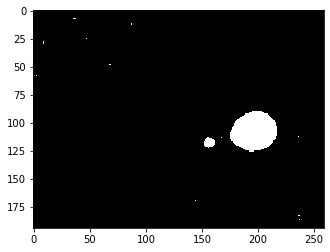

In [43]:
orig_map = plt.cm.get_cmap('Greys')
rev_map = orig_map.reversed()
plt.imshow(X, cmap=rev_map);

In [44]:
diag = gudhi_tda(p)

In [45]:
num_b0, num_b1 = couting_b0_b1(diag)

In [46]:
num_b0

1

In [47]:
num_b1

13